# Introduction to DESI Spectra

The goal of this notebook is to demonstrate how to read in and manipulate DESI spectra using simulated spectra created as part of a DESI Data Challenge.

If you identify any errors or have requests for additional functionality please create a new issue on https://github.com/desihub/tutorials/issues or send a note to desi-data@desi.lbl.gov.

Last updated December 2019 using DESI software release 19.10.

## Getting started

### Using NERSC

The easiest way to get started is to use the jupyter server at NERSC so that you don't need to
install any code or download any data locally.

If you need a NERSC account, see https://desi.lbl.gov/trac/wiki/Computing/AccessNersc

Then do the one-time jupyter configuration described at https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC

From a NERSC command line, checkout a copy of the tutorial code, *e.g.* from cori.nersc.gov
```console
mkdir -p $HOME/desi/
cd $HOME/desi/
git clone https://github.com/desihub/tutorials
```
And then go to https://jupyter.nersc.gov, login, navigate to where you checked out this package (*e.g.* `$HOME/desi/tutorials`), and double-click on `Intro_to_DESI_spectra.ipynb`.

This tutorial has been tested using the "DESI 19.10" kernel installed at NERSC.  To get an equivalent environment from a cori command line:
```console
source /global/common/software/desi/desi_environment.sh 19.10
```

## Import required modules

In [1]:
import os
import numpy as np
import healpy as hp
from glob import glob
import fitsio
from collections import defaultdict

from desitarget.targetmask import desi_mask
import desispec.io

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


If you are running locally and any of these fail, 
you should go back through the [installation instructions]( https://desi.lbl.gov/trac/wiki/Pipeline/GettingStarted/Laptop) and/or email desi-data@desi.lbl.gov if you get stuck.
If you are running from jupyter.nersc.gov and have problems, double check that your kernel is "DESI 19.10".

## Environment variables and data

Like BOSS, DESI uses environment variables to define the base directories for where to find data.  The below paths are for NERSC, but if you are running locally or want to access a different dataset, change these as needed to wherever your dataset is.

Spectro production runs are grouped under `$DESI_SPECTRO_REDUX`, with `$SPECPROD` indicating which run to use, such that the data are under `$DESI_SPECTRO_REDUX/$SPECPROD`.  *e.g.* during operations, official productions will be in `$DESI_SPECTRO_REDUX=/project/projectdirs/desi/spectro/redux` and `$SPECPROD` would be the name for individual data assemblies, *e.g.* `$SPECPROD=DA1`.  In this case, we'll use reference run 19.10 data.

In [2]:
%set_env DESI_SPECTRO_REDUX=/project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/
%set_env SPECPROD=mini

env: DESI_SPECTRO_REDUX=/project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/
env: SPECPROD=mini


`desispec.io.specprod_root` can handle the environment variable path wrangling for you:

In [3]:
reduxdir = desispec.io.specprod_root()
print(reduxdir)

/project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/mini


In [4]:
#- Do check that these are set correctly before proceeding
def check_env():
    for env in ('DESI_SPECTRO_REDUX', 'SPECPROD'):
        if env in os.environ:
            print('${}={}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))

    reduxdir = desispec.io.specprod_root()
    if not os.path.exists(reduxdir):
        print("ERROR: {} doesn't exist; check $DESI_SPECTRO_REDUX/$SPECPROD".format(reduxdir))
    else:
        print('OK: {} exists'.format(reduxdir))

check_env()

$DESI_SPECTRO_REDUX=/project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/
$SPECPROD=mini
OK: /project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/mini exists


## Data Model for the spectra

### Directory structure

Spectra from individual exposures are in the `exposures` directory.  But since DESI will take multiple exposures of overlapping tiles, the data from any given target or patch of sky could be spread across multiple files in multiple directories.  To simplify this, the calibrated spectra are repackaged into a `spectra-64` directory, where all spectra for a given healpix on the sky are grouped together.  See an appendix to this tutorial for a quick overview of healpix.

The directory structure is: 

```
$DESI_SPECTRO_REDUX/$SPECPROD/spectra-{nside}/{group}/{pix}/*-{nside}-{pix}.fits
```

where
  * `nside` is the healpix nside hierarchy level with a default is
    nside=64 corresponding to pixels of 0.84 $deg^2$ with a few thousand targets each.
  * `group = nside//100` to avoid having thousands of directories at the same level
  * `pix` is the healpixel number using the *nested* scheme.

For example for `nside=64` and `pixel=16879`:

```
$DESI_SPECTRO_REDUX/$SPECTRO/spectra-64/168/16879/spectra-64-16879.fits
$DESI_SPECTRO_REDUX/$SPECTRO/spectra-64/168/16879/zbest-64-16879.fits
```

where the first file contains the spectra and the second file contains information on the best-fit redshifts from the [redrock](https://github.com/desihub/redrock) code.

Let's poke around in these directories.

In [5]:
basedir = os.path.join(os.getenv("DESI_SPECTRO_REDUX"),os.getenv("SPECPROD"),"spectra-64")
subdir = os.listdir(basedir)
print(basedir)
print(subdir)

/project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/mini/spectra-64
['53', '56', '52']


In [6]:
basedir = os.path.join(basedir,subdir[0])
subdir = os.listdir(basedir)
pixnums = np.array([int(pixnum) for pixnum in subdir])
print(basedir)
print(subdir)

/project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/mini/spectra-64/53
['5302', '5310', '5311', '5346', '5307', '5308', '5309', '5303', '5304', '5305', '5352', '5306', '5354', '5300', '5301']


In [7]:
basedir = os.path.join(basedir,subdir[0])
subdir = os.listdir(basedir)
print(basedir)
print(subdir)

/project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/mini/spectra-64/53/5302
['spectra-64-5302.fits', 'redrock-64-5302.h5', 'zbest-64-5302.fits']


`desispec.io.findfile` provides utility functions for the path wrangling, *e.g.*:

In [8]:
desispec.io.findfile('spectra', groupname=5302)

'/project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/mini/spectra-64/53/5302/spectra-64-5302.fits'

### spectra file format

What about the Data Model for the spectra themselves?

In [9]:
specfiles = sorted(glob(reduxdir+'/spectra-64/*/*/spectra*.fits'))
specfilename = specfiles[2]
DM = fitsio.FITS(specfilename)
DM


  file: /project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/mini/spectra-64/52/5263/spectra-64-5263.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      BINARY_TBL      SCORES
  3      IMAGE_HDU       B_WAVELENGTH
  4      IMAGE_HDU       B_FLUX
  5      IMAGE_HDU       B_IVAR
  6      IMAGE_HDU       B_MASK
  7      IMAGE_HDU       B_RESOLUTION
  8      IMAGE_HDU       R_WAVELENGTH
  9      IMAGE_HDU       R_FLUX
  10     IMAGE_HDU       R_IVAR
  11     IMAGE_HDU       R_MASK
  12     IMAGE_HDU       R_RESOLUTION
  13     IMAGE_HDU       Z_WAVELENGTH
  14     IMAGE_HDU       Z_FLUX
  15     IMAGE_HDU       Z_IVAR
  16     IMAGE_HDU       Z_MASK
  17     IMAGE_HDU       Z_RESOLUTION

HDU 0 is blank.  The others should be used by name, not by number since the order could vary.

`FIBERMAP` stores the mapping of the imaging information used to target and place a fiber on the source.

The other HDUs contain the wavelength arrays, flux, inverse variance (ivar), mask (0 is good), and spectral resolution data for each of the "B", "R", and "Z" cameras.

Let's start by looking at the fibermap.

In [10]:
fm = fitsio.read(specfilename,'FIBERMAP')
fm.dtype.descr

[('TARGETID', '>i8'),
 ('DESI_TARGET', '>i8'),
 ('BGS_TARGET', '>i8'),
 ('MWS_TARGET', '>i8'),
 ('SECONDARY_TARGET', '>i8'),
 ('TARGET_RA', '>f8'),
 ('TARGET_DEC', '>f8'),
 ('TARGET_RA_IVAR', '>f8'),
 ('TARGET_DEC_IVAR', '>f8'),
 ('BRICKID', '>i8'),
 ('BRICK_OBJID', '>i8'),
 ('MORPHTYPE', '|S4'),
 ('PRIORITY', '>i4'),
 ('SUBPRIORITY', '>f8'),
 ('REF_ID', '>i8'),
 ('PMRA', '>f4'),
 ('PMDEC', '>f4'),
 ('REF_EPOCH', '>f4'),
 ('PMRA_IVAR', '>f4'),
 ('PMDEC_IVAR', '>f4'),
 ('RELEASE', '>i2'),
 ('FLUX_G', '>f4'),
 ('FLUX_R', '>f4'),
 ('FLUX_Z', '>f4'),
 ('FLUX_W1', '>f4'),
 ('FLUX_W2', '>f4'),
 ('FLUX_IVAR_G', '>f4'),
 ('FLUX_IVAR_R', '>f4'),
 ('FLUX_IVAR_Z', '>f4'),
 ('FLUX_IVAR_W1', '>f4'),
 ('FLUX_IVAR_W2', '>f4'),
 ('FIBERFLUX_G', '>f4'),
 ('FIBERFLUX_R', '>f4'),
 ('FIBERFLUX_Z', '>f4'),
 ('FIBERFLUX_W1', '>f4'),
 ('FIBERFLUX_W2', '>f4'),
 ('FIBERTOTFLUX_G', '>f4'),
 ('FIBERTOTFLUX_R', '>f4'),
 ('FIBERTOTFLUX_Z', '>f4'),
 ('FIBERTOTFLUX_W1', '>f4'),
 ('FIBERTOTFLUX_W2', '>f4'),
 ('MW_TRA

`TARGETID` is the unique mapping from target information to a fiber. So, if you wanted to look up full imaging information for a spectrum, you can map back to target files using `TARGETID`.

Just out of interest, are the RAs and Decs of these objects in the expected HEALPix pixel?

In [11]:
pixnums = hp.ang2pix(64, fm["TARGET_RA"], fm["TARGET_DEC"], nest=True, lonlat=True)
print(np.min(pixnums),np.max(pixnums))
print(specfilename)

5263 5263
/project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/mini/spectra-64/52/5263/spectra-64-5263.fits


I wonder what (roughly) the entirety of this pixel looks like, as mapped out by sources with spectra:

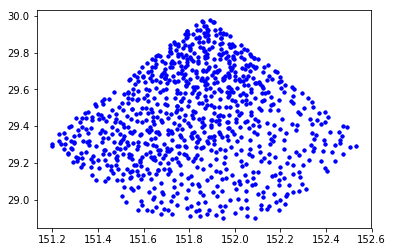

In [12]:
plt.plot(fm["TARGET_RA"],fm["TARGET_DEC"],'b.')

You can see a different density in different parts of the tiles, due to different overlapping exposures.  Let's repeat, color coding by exposure number.

expid 32 includes 90 targets
expid 39 includes 507 targets
expid 40 includes 507 targets
expid 10 includes 281 targets
expid 11 includes 281 targets
expid 18 includes 10 targets
expid 19 includes 10 targets
expid 31 includes 90 targets


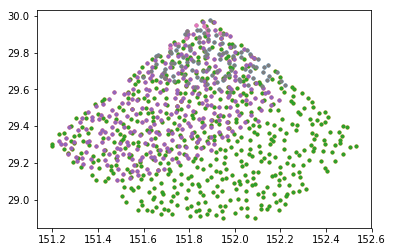

In [13]:
for expid in set(fm['EXPID']):
    ii = (fm['EXPID'] == expid)
    print('expid {} includes {} targets'.format(expid, np.count_nonzero(ii)))
    plot(fm['TARGET_RA'][ii], fm['TARGET_DEC'][ii], '.')

Note that in addition to having multiple tiles, we also have multiple exposures of the same tile resulting in multiple spectra of the same targets.

In [14]:
DM


  file: /project/projectdirs/desi/datachallenge/reference_runs/19.10/spectro/redux/mini/spectra-64/52/5263/spectra-64-5263.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      FIBERMAP
  2      BINARY_TBL      SCORES
  3      IMAGE_HDU       B_WAVELENGTH
  4      IMAGE_HDU       B_FLUX
  5      IMAGE_HDU       B_IVAR
  6      IMAGE_HDU       B_MASK
  7      IMAGE_HDU       B_RESOLUTION
  8      IMAGE_HDU       R_WAVELENGTH
  9      IMAGE_HDU       R_FLUX
  10     IMAGE_HDU       R_IVAR
  11     IMAGE_HDU       R_MASK
  12     IMAGE_HDU       R_RESOLUTION
  13     IMAGE_HDU       Z_WAVELENGTH
  14     IMAGE_HDU       Z_FLUX
  15     IMAGE_HDU       Z_IVAR
  16     IMAGE_HDU       Z_MASK
  17     IMAGE_HDU       Z_RESOLUTION

The remaining extensions store the wavelength, flux, inverse variance on the flux, mask and resolution matrix for the B, R and Z arms of the spectrograph. Let's determine the wavelength coverage of each spectrograph:

In [15]:
bwave = fitsio.read(specfilename, 'B_WAVELENGTH')
rwave = fitsio.read(specfilename, 'R_WAVELENGTH')
zwave = fitsio.read(specfilename, 'Z_WAVELENGTH')
print("B coverage: {:.1f} to {:.1f} Angstroms".format(np.min(bwave),np.max(bwave)))
print("R coverage: {:.1f} to {:.1f} Angstroms".format(np.min(rwave),np.max(rwave)))
print("Z coverage: {:.1f} to {:.1f} Angstroms".format(np.min(zwave),np.max(zwave)))

B coverage: 3569.3 to 5948.5 Angstroms
R coverage: 5625.3 to 7740.5 Angstroms
Z coverage: 7435.3 to 9833.7 Angstroms


## Reading in and Displaying spectra

Now that we understand the Data Model, let's plot some spectra. To start, let's use the file we've already been manipulating and read in the flux to go with the wavelengths we already have.

In [16]:
bflux = fitsio.read(specfilename,'B_FLUX')
rflux = fitsio.read(specfilename,'R_FLUX')
zflux = fitsio.read(specfilename,'Z_FLUX')

Note that the wavelength arrays are 1-D (every spectrum in the spectral file is mapped to the same binning in wavelength) but the flux array (and flux_ivar, mask etc. arrays) are 2-D, because they contain multiple spectra:

In [17]:
print(bwave.shape)
print(bflux.shape)

(2975,)
(1776, 2975)


Let's plot the zeroth spectrum in this file (*i.e.* in this HEALPix grouping):

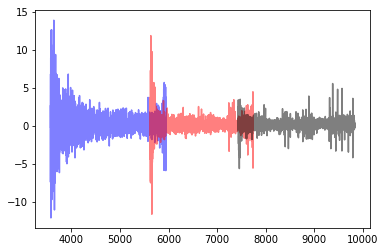

In [18]:
spectrum = 0
plt.plot(bwave,bflux[spectrum], 'b', alpha=0.5)
plt.plot(rwave,rflux[spectrum], 'r', alpha=0.5)
plt.plot(zwave,zflux[spectrum], 'k', alpha=0.5)

## A DESI-specific spectrum reader

Note that, for illustrative purposes, we discussed the Data Model in detail and read in the required files individually from that Data Model. But, the DESI data team has also developed standalone functions in `desispec.io` to facilitate reading in the plethora of information in the spectral files. For example:

In [19]:
specobj = desispec.io.read_spectra(specfilename)

The wavelengths and flux in each band are then available as dictionaries in the `wave` and `flux` attributes:

In [20]:
specobj.wave

{'b': array([3569.3, 3570.1, 3570.9, ..., 5946.9, 5947.7, 5948.5]),
 'r': array([5625.3, 5626.1, 5626.9, ..., 7738.9, 7739.7, 7740.5]),
 'z': array([7435.3, 7436.1, 7436.9, ..., 9832.1, 9832.9, 9833.7])}

In [21]:
specobj.flux

{'b': array([[  2.57964778,   0.90077299,  -7.44606876, ...,  -5.62826347,
          -0.67599046,  -2.67901731],
        [ -0.79662216,   0.18848716,  -0.06733219, ...,  -3.27793503,
           0.7519989 ,  -0.65268725],
        [  2.36938477,   4.06980658,  -3.48006105, ...,   2.58276534,
          -1.88581336,   0.93888056],
        ...,
        [  8.11109734,  22.23205185,  13.13126278, ...,  10.08240223,
         -15.48243332,  -7.76523924],
        [  3.38191247,  -0.818887  ,  14.6403656 , ...,  -2.92670012,
           0.09148289,  -2.22726941],
        [  7.4153204 ,  -4.68519878,   1.22845972, ...,  39.34307861,
          13.22149563,  10.73699379]]),
 'r': array([[ -7.42201853,   3.7156086 ,  -5.46633625, ...,  -5.60032797,
           0.23082392,   2.01226997],
        [  0.94139391,  -1.64227998,  -4.3447566 , ...,   4.24056053,
          -1.41529226,  -0.06547195],
        [ -3.14914489,   5.7022171 ,  -5.34978485, ...,   1.8485167 ,
          -1.21107042,   2.03942823],
   

So, to plot the "zeroth" spectrum:

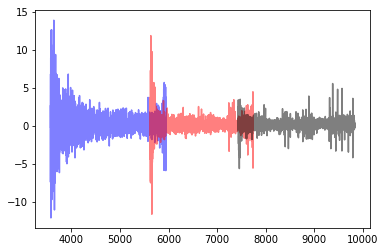

In [22]:
spectrum = 0
plt.plot(specobj.wave["b"],specobj.flux["b"][spectrum],color='b', alpha=0.5)
plt.plot(specobj.wave["r"],specobj.flux["r"][spectrum],color='r', alpha=0.5)
plt.plot(specobj.wave["z"],specobj.flux["z"][spectrum],color='k', alpha=0.5)

which should look very similar to one of the first plots we made earlier in the tutorial. 

The fibermap information is available as a table in the `fibermap` attribute:

In [23]:
specobj.fibermap

TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,SECONDARY_TARGET,TARGET_RA,TARGET_DEC,TARGET_RA_IVAR,TARGET_DEC_IVAR,BRICKID,BRICK_OBJID,MORPHTYPE,PRIORITY,SUBPRIORITY,REF_ID,PMRA,PMDEC,REF_EPOCH,PMRA_IVAR,PMDEC_IVAR,RELEASE,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERFLUX_W1,FIBERFLUX_W2,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FIBERTOTFLUX_W1,FIBERTOTFLUX_W2,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,EBV,PHOTSYS,OBSCONDITIONS,NUMOBS_INIT,PRIORITY_INIT,NUMOBS_MORE,HPXPIXEL,FIBER,PETAL_LOC,DEVICE_LOC,LOCATION,FIBERSTATUS,OBJTYPE,LAMBDA_REF,FIBERASSIGN_X,FIBERASSIGN_Y,FA_TARGET,FA_TYPE,NUMTARGET,FIBER_RA,FIBER_DEC,FIBER_RA_IVAR,FIBER_DEC_IVAR,PLATEMAKER_X,PLATEMAKER_Y,PLATEMAKER_RA,PLATEMAKER_DEC,NUM_ITER,SPECTROID,BRICKNAME,LAMBDAREF,DELTA_X,DELTA_Y,NIGHT,EXPID,TILEID
int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,bytes4,int32,float64,int64,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes1,int32,int64,int64,int32,int64,int32,int32,int32,int32,int32,bytes3,float32,float32,float32,int64,uint8,int16,float64,float64,float32,float32,float32,float32,float32,float32,int32,int32,bytes8,float64,float64,float64,int32,int32,int32
288230398226336747,2,0,0,0,151.91505432128906,29.924673080444336,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.48265588,0.6645226,1.7398417,11.853331,12.67698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,4156,8,309,8309,0,TGT,5400.0,-255.41039,-147.13077,0,0,0,151.91505432128906,29.924673080444336,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p300,5400.0,0.0,0.0,20200315,10,28408
288230398226336553,2,0,0,0,151.9975128173828,29.765117645263672,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.5319718,0.48154348,0.69185185,1.3173035,0.9313376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,4159,8,393,8393,0,TGT,5400.0,-275.28625,-187.82756,0,0,0,151.9975128173828,29.765117645263672,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p297,5400.0,0.0,0.0,20200315,10,28408
288230398226336847,2,0,0,0,151.97427368164062,29.753976821899414,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.36775583,0.469278,0.5855999,0.6464042,0.4328891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,4168,8,372,8372,0,TGT,5400.0,-270.14102,-190.58168,0,0,0,151.97427368164062,29.753976821899414,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p297,5400.0,0.0,0.0,20200315,10,28408
288230398226336942,2,0,0,0,152.0714111328125,29.780677795410156,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.68889505,0.9586256,1.8688653,2.1837597,1.4608332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,4169,8,414,8414,0,TGT,5400.0,-291.89987,-184.13995,0,0,0,152.0714111328125,29.780677795410156,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p297,5400.0,0.0,0.0,20200315,10,28408
288230398226336965,2,0,0,0,151.96197509765625,29.900096893310547,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.8973277,1.0362706,2.224952,3.1142735,2.4632285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,4173,8,328,8328,0,TGT,5400.0,-266.1019,-153.44757,0,0,0,151.96197509765625,29.900096893310547,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p300,5400.0,0.0,0.0,20200315,10,28408
288230398226336662,2,0,0,0,151.93479919433594,29.8477783203125,0.0,0.0,0,0,,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.6727076,0.80210084,1.2960424,1.9260666,1.1915287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999,0.999,0.999,0.001,S,0,0,0,0,0,4176,8,330,8330,0,TGT,5400.0,-260.4315,-166.60097,0,0,0,151.93479919433594,29.8477783203125,0.0,0.0,0.0,0.0,0.0,0.0,2,8,1519p297,5400.0,0.0,0.0,20200315,10,28408
288230398226336809,2,0,0,0,1

The entries with `TARGETID`=-1 are spectra for which the fiber was not assigned to a target, e.g. because that fiber was broken or because it randomly didn't cover any input targets (this latter case should never happen in the real survey).  There can also be multiple spectra for a single `TARGETID` from multiple exposures so there is a utility function for getting the `TARGETID`s in this file:

In [24]:
specobj.target_ids()

288230398226336747
288230398226336553
288230398226336847
288230398226336942
288230398226336965
288230398226336662
288230398226336809
288230398226336834
288230398226336598
288230398226336904
288230398226336814


There are also functions for getting the number of spectra and selecting a subset of spectra.  All of the information that could be read in from the different extensions of the spectral file can be retrieved from the `specobj` object. Here's what's available:

In [25]:
dir(specobj)

['R',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bands',
 '_ftype',
 '_single',
 'bands',
 'extra',
 'fibermap',
 'flux',
 'ftype',
 'ivar',
 'mask',
 'meta',
 'num_spectra',
 'num_targets',
 'resolution_data',
 'scores',
 'select',
 'target_ids',
 'update',
 'wave',
 'wavelength_grid']

## Target classes

What about if we only want to plot spectra of certain target classes? The targeting information is stored in the `DESI_TARGET`, `BGS_TARGET` and `MWS_TARGET` entries of the fibermap array:

In [26]:
specobj.fibermap.info

<Table length=1776>
       name        dtype 
----------------- -------
         TARGETID   int64
      DESI_TARGET   int64
       BGS_TARGET   int64
       MWS_TARGET   int64
 SECONDARY_TARGET   int64
        TARGET_RA float64
       TARGET_DEC float64
   TARGET_RA_IVAR float64
  TARGET_DEC_IVAR float64
          BRICKID   int64
      BRICK_OBJID   int64
        MORPHTYPE  bytes4
         PRIORITY   int32
      SUBPRIORITY float64
           REF_ID   int64
             PMRA float32
            PMDEC float32
        REF_EPOCH float32
        PMRA_IVAR float32
       PMDEC_IVAR float32
          RELEASE   int16
           FLUX_G float32
           FLUX_R float32
           FLUX_Z float32
          FLUX_W1 float32
          FLUX_W2 float32
      FLUX_IVAR_G float32
      FLUX_IVAR_R float32
      FLUX_IVAR_Z float32
     FLUX_IVAR_W1 float32
     FLUX_IVAR_W2 float32
      FIBERFLUX_G float32
      FIBERFLUX_R float32
      FIBERFLUX_Z float32
     FIBERFLUX_W1 float32
     FIBERFLUX_W2 

and which target corresponds to which targeting bit is stored in the desitarget mask (we imported this near the beginning of the notebook).

In [27]:
desi_mask

desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 1}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK|GRAY', 'priorities': {'UNOBS': 3000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000}, 'numobs': 1}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3500, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3400}, 'numobs': 4}]
  - [LRG_NORTH,        8, "LRG cuts tuned for Bok/Mosaic data", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 0, 'DONE': 0, 'OBS': 0, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 0, 'MORE_ZGOOD': 0}, 'numobs': 0}]
  - [ELG_NORTH,        9, "ELG cuts tuned for Bok/Mosaic data", {'obsconditions': 'DARK|GRAY', 'priorities': {'UNOBS': 0, 'DONE': 0, 'OBS': 0, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 0, 'MORE_ZGOOD': 0}, 'numobs': 0}]
  - [QSO_NORTH,

Let's find the indexes of all standard F-stars in the spectral file:

In [28]:
stds = np.where(specobj.fibermap["DESI_TARGET"] & desi_mask.mask("STD_FAINT|STD_BRIGHT"))[0]
print(stds)

[ 203  235  484  516  810  863  897  984 1030 1150 1265 1317 1370 1404
 1491 1537 1657 1772]


Where were these located on the original plate-fiber mapping?

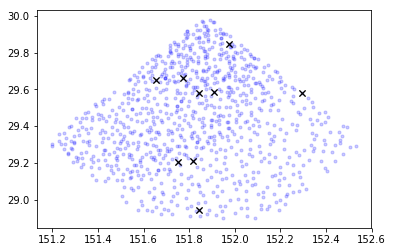

In [29]:
fm = specobj.fibermap   #- shorthand
plt.plot(fm["TARGET_RA"],fm["TARGET_DEC"],'b.', alpha=0.1)
plt.plot(fm["TARGET_RA"][stds],fm["TARGET_DEC"][stds],'kx')

Recall that there can be (will be!) more than one spectrum per object

In [30]:
num_standard_stars = len(set(specobj.fibermap['TARGETID'][stds]))
num_stdstar_exposures = np.count_nonzero(stds)
print('{} exposures of {} standards'.format(num_stdstar_exposures, num_standard_stars))

18 exposures of 9 standards


Let's take a look at the spectra of these standard stars, plotting just the first spectrum from each camera for the first 9 standards.

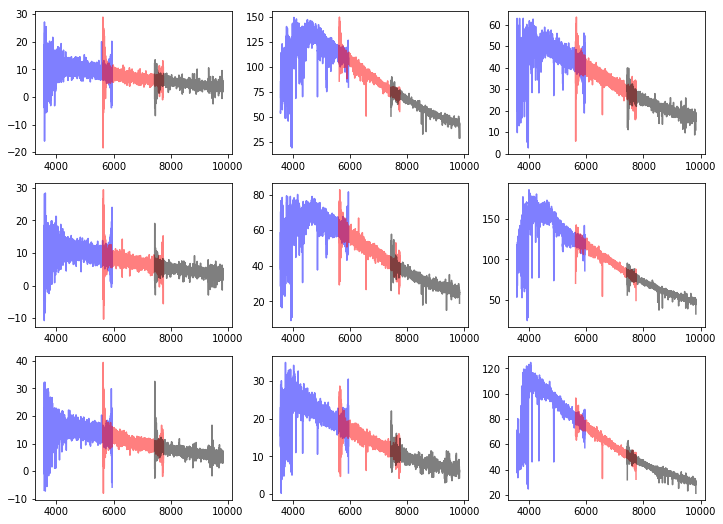

In [31]:
targetids = list(set(specobj.fibermap['TARGETID'][stds]))
figure(figsize=(12,9))
for i, tx in enumerate(targetids[0:9]):
    subplot(3,3,i+1)
    sp = specobj.select(targets=[tx,])
    plt.plot(sp.wave['b'], sp.flux['b'][0], 'b-', alpha=0.5)
    plt.plot(sp.wave['r'], sp.flux['r'][0], 'r-', alpha=0.5)
    plt.plot(sp.wave['z'], sp.flux['z'][0], 'k-', alpha=0.5)
    # plt.show()

These seem realistic. Let's zoom in on some of the Balmer series for the zeroth standard:

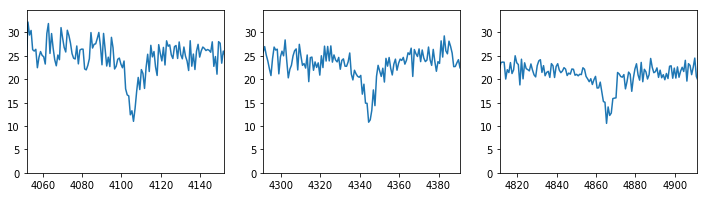

In [32]:
Balmer = [4102,4341,4861]
halfwindow = 50
figure(figsize=(4*len(Balmer), 3))
for i in range(len(Balmer)):
    subplot(1,len(Balmer),i+1)
    plt.axis([Balmer[i]-halfwindow,Balmer[i]+halfwindow,0,np.max(bflux[stds[0]])])
    plt.plot(bwave,bflux[stds[0]])
    # plt.show()

## Redshifts

The directory from which we took these spectra also contains information on the best-fit redshifts for the spectra from the [redrock](https://github.com/desihub/redrock) code. The first pixel we looked at didn't have very many targets, so we'll pick one with more targets for studying the redshifts.

In [33]:
zfilename = specfilename.replace('spectra-64-', 'zbest-64-')
zs = fitsio.read(zfilename)
zs.dtype.descr

[('TARGETID', '>i8'),
 ('CHI2', '>f8'),
 ('COEFF', '>f8', (10,)),
 ('Z', '>f8'),
 ('ZERR', '>f8'),
 ('ZWARN', '>i8'),
 ('NPIXELS', '>i8'),
 ('SPECTYPE', '|S6'),
 ('SUBTYPE', '|S20'),
 ('NCOEFF', '>i8'),
 ('DELTACHI2', '>f8'),
 ('NUMEXP', '>i4'),
 ('NUMTILE', '>i4')]

Note that due to repeated observations, there could be a different number of spectra than final redshifts, meaning that there isn't a row-by-row mapping between spectra and redshifts...

In [34]:
print(zs.shape[0], 'redshifts')
print(specobj.num_targets(), 'targets')
print(specobj.num_spectra(), 'spectra')
print(specobj.flux['b'].shape, 'shape of flux["b"]')

880 redshifts
880 targets
1776 spectra
(1776, 2975) shape of flux["b"]


...but the `TARGETID` (which *is* intended to be unique) is in this file, too, allowing sources to be uniquely mapped from targeting, to spectra, to redshift. Let's extract all sources that were targeted as quasars using the fibermap information from the spectral file, and plot the first 20:

48 QSOs


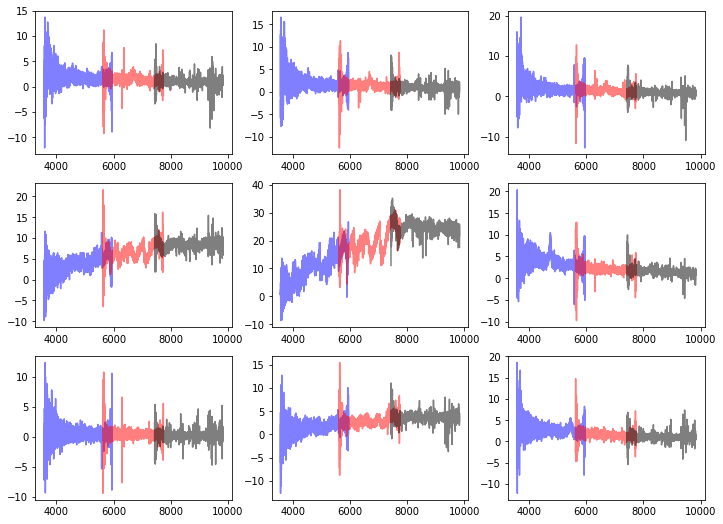

In [35]:
qsos = np.where(specobj.fibermap["DESI_TARGET"] & desi_mask["QSO"])[0]
print(len(qsos), 'QSOs')
plt.figure(figsize=(12,9))
for i in range(len(qsos))[0:9]:
    plt.subplot(3,3,i+1)
    plt.plot(bwave,bflux[qsos[i]],'b', alpha=0.5)
    plt.plot(rwave,rflux[qsos[i]],'r', alpha=0.5)
    plt.plot(zwave,zflux[qsos[i]],'k', alpha=0.5)
    # plt.show()

Let's match these quasar targets to the redshift file on `TARGETID` to extract their best-fit redshifts from `redrock`:

In [36]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zqsos = [index for item in fm[qsos]["TARGETID"] for index in dd[item] if item in dd]

That might be hard to follow at first glance, but all I did was use some "standard" python syntax to match the indices in `zs` (the ordering of objects in the `redrock` redshift file) to those for quasars in `fm` (the ordering of quasars in the fibermap file), on the unique `TARGETID`, such that the indices stored in `qsos` for `fm` point to the corresponding indices in `zqsos` for `zs`. This might help illustrate the result:

In [37]:
zs[zqsos]["TARGETID"][0:7], fm[qsos]["TARGETID"][0:7]

(array([288230398226338513, 288230398226338513, 288230398226338513,
        288230398226338667, 288230398226338672, 288230398226338506,
        288230398226338512]), <Column name='TARGETID' dtype='int64' length=7>
 288230398226338513
 288230398226338513
 288230398226338513
 288230398226338667
 288230398226338672
 288230398226338506
 288230398226338512)

Let's see what best-fit template `redrock` assigned to each quasar. This information is stored in the `SPECTYPE` column.

In [38]:
zs[zqsos]["SPECTYPE"]

array([b'QSO', b'QSO', b'QSO', b'STAR', b'STAR', b'QSO', b'QSO', b'STAR',
       b'QSO', b'QSO', b'QSO', b'STAR', b'GALAXY', b'STAR', b'QSO',
       b'STAR', b'GALAXY', b'QSO', b'STAR', b'QSO', b'STAR', b'QSO',
       b'QSO', b'QSO', b'STAR', b'QSO', b'STAR', b'STAR', b'QSO', b'QSO',
       b'STAR', b'QSO', b'QSO', b'QSO', b'STAR', b'GALAXY', b'STAR',
       b'QSO', b'STAR', b'GALAXY', b'QSO', b'STAR', b'QSO', b'STAR',
       b'QSO', b'QSO', b'QSO', b'STAR'], dtype='|S6')

Or for standard stars:

In [39]:
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zstds = [index for item in fm[stds]["TARGETID"] for index in dd[item] if item in dd]

For stars, we can also display the type of star that `redrock` fit (this is stored in the `SUBTYPE` column):

In [40]:
zipper = zip(zs[zstds]["SUBTYPE"],zs[zstds]["SPECTYPE"])
for sub, spec in zipper:
    print("{}-{}".format(sub.decode('utf-8'),spec.decode('utf-8')))

F-STAR
F-STAR
F-STAR
F-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
F-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
G-STAR
F-STAR


(here the conversion to `utf-8` is simply for display purposes because the strings in `SUBTYPE` and `SPECTYPE` are stored as bytes instead of unicode).

OK, back to our quasars. Let's plot the quasar targets that *are identified as quasars* , but add a label for the `SPECTYPE` and the redshift fit by `redrock`. I'll also add some median filtering and over-plot some (approximate) typical quasar emission lines at the redrock redshift (if those lines would fall in the DESI wavelength coverage):

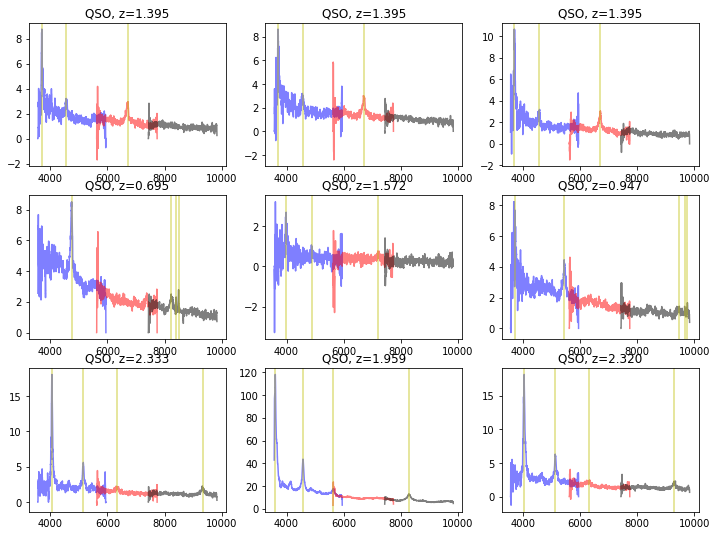

In [41]:
from scipy.signal import medfilt

qsoid = np.where(zs[zqsos]["SPECTYPE"] == b'QSO')[0]
qsolines = np.array([1216,1546,1906,2800,4853,4960,5008])

wave = specobj.wave
flux = specobj.flux

plt.figure(figsize=(12,9))
for i in range(len(qsoid))[0:9]:
    plt.subplot(3,3,1+i)
    spectype = zs[zqsos[qsoid[i]]]["SPECTYPE"].decode('utf-8')
    z = zs[zqsos[qsoid[i]]]["Z"]
    plt.plot(wave['b'], medfilt(flux['b'][qsos[qsoid[i]]], 15), 'b', alpha=0.5)
    plt.plot(wave['r'], medfilt(flux['r'][qsos[qsoid[i]]], 15), 'r', alpha=0.5)
    plt.plot(wave['z'], medfilt(flux['z'][qsos[qsoid[i]]], 15), 'k', alpha=0.5)
    plt.title("{}, z={:.3f}".format(spectype,z))
    for line in qsolines:
        if ((1+z)*line > np.min(bwave)) & ((1+z)*line < np.max(zwave)):
            axvline((1+z)*line, color='y', alpha=0.5)

## Appendix: code versions used

In [42]:
from desitutorials import print_code_versions as pcv
print("This tutorial last ran successfully to completion using the following versions of the following modules:") 
pcv()

This tutorial last ran successfully to completion using the following versions of the following modules:
python      : 3.6.6
numpy       : 1.16.4
scipy       : 1.3.0
astropy     : 2.0.14
yaml        : 5.1.1
matplotlib  : 2.1.2
fitsio      : 0.9.11
healpy      : 1.12.9
desiutil    : 2.0.1
desispec    : 0.31.0
desitarget  : 0.33.3
specter     : 0.9.1
speclite    : 0.9dev514


## Appendix: Healpix overview

DESI uses healpix for grouping spectra on the sky.  It is somewhat overkill for our needs, but it has a nice nested pixel structure and has good fast libraries for common operations like determining which pixels cover which points on the sky.

If you aren't familiar with HEALPix, it is an equal-area splitting of the sphere, where the sphere is initially divided into 12 equal-area pixels, and then each of those pixels is divided into 4 new equal-area pixels as `nside` increases (a quad tree). Schematically, here's how `nside` corresponds to pixel *area* in degrees:

In [43]:
sphere_area = 4*180.*180./np.pi
for i in range(10):
    nside = 2**i
    npix = 12*nside**2
    hpx_area = sphere_area / npix
    print(nside, npix, hpx_area)

1 12 3437.746770784939
2 48 859.4366926962348
4 192 214.8591731740587
8 768 53.714793293514674
16 3072 13.428698323378669
32 12288 3.357174580844667
64 49152 0.8392936452111668
128 196608 0.2098234113027917
256 786432 0.052455852825697924
512 3145728 0.013113963206424481


The `nside` at which the example spectra are grouped therefore corresponds to ~0.84 sq. deg. Note that I could have checked this more easily (but less pedagogically) using the useful python [HEALPix](https://healpy.readthedocs.io/en/latest/) library:

In [44]:
hp.nside2pixarea(64,degrees=True)

0.8392936452111668

The spectra are stored in this fashion so that they are grouped (roughly) contiguously on the sky, with a reasonable number of spectra in each directory. It's easy to derive the approximate RA/Dec near each pixel number (note that we sneakily stored the pixel numbers as `pixnums` when we were examining the directory structure):

In [45]:
ras, decs = hp.pix2ang(64, pixnums, nest=True, lonlat=True)

Note that **the DESI Data Model will always use the _NESTED_ scheme for HEALPix**.

In [46]:
zipper = list(zip(pixnums,ras,decs))
for pix,ra,dec in zipper[0:10]:
    print("Pixel(nside=64): {} RA: {} DEC: {}".format(pix,ra,dec))
if len(zipper) > 10:
    print('...')

Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
Pixel(nside=64): 5263 RA: 151.875 DEC: 29.313198964168343
...
